# Tutorial 1  Visium  HD human colorectal cancer

## Import relevant packages

In [1]:
import sys
sys.path.append("..")
import STWave
from STWave.measure import measure_resources
import scanpy as sc
import numpy as np
import time

## Read data

In [2]:
data_path = '/home/cavin/jt/spatial_data/bighumancrc'
adata = sc.read_visium(data_path)
adata

/home/cavin/anaconda3/envs/tao/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/cavin/anaconda3/envs/tao/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 545913 × 18085
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## Data preprocess

In [3]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000,subset=True)
sc.pp.normalize_total(adata, target_sum=1e4, exclude_highly_expressed=True)
sc.pp.scale(adata,zero_center=True)
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 545913 × 3000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg'
    obsm: 'spatial'

In [4]:
start = time.time()
adata.X = adata.X.astype(np.float32)
sc.pp.pca(adata, svd_solver='randomized', n_comps=200)
print('PCA time:', time.time() - start)
adata

PCA time: 177.7967071533203


AnnData object with n_obs × n_vars = 545913 × 3000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'pca'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'

## Construct spatial networks and pruning networks

In [5]:
STWave.Cal_Spatial_Net(adata,k_cutoff=8)
STWave.Cal_Precluster_Net(adata,is_pca=True,verbose=True,pcs=200)
adata

------Calculating spatial graph...
Spatial graph contains 4367304 edges, 545913 cells.
8.0000 neighbors per cell on average.
Spatial graph calculation time: 17.99 seconds
------Calculating precluster graph...
begining pcs use n_com = 200
Precluster spatial graph contains 1931860 edges, 545913 cells.
3.5388 neighbors per cell on average.
Precluster graph calculation time: 433.93 seconds


AnnData object with n_obs × n_vars = 545913 × 3000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'pca', 'Spatial_Net', 'Precluster_Net'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'

## Train the STWave model
 ```STWave.Trainer()``` Args
 - dim_reduction (str, optional): Dimensional reduction method ('PCA', 'HVG', or None). Defaults to 'PCA'.
 - batch_data (bool, optional): Whether to split data into batches for training, defaults to False.
 - num_batch_x_y (Tuple[int, int], optional): Number of batches along x and y axes if batch_data=True, defaults to None.
 - device ('cuda', 'cpu'): 'cuda' or 'cpu'.

In [6]:
trainer = STWave.Trainer(adata,dim_reduction='PCA',batch_data=True,num_batch_x_y=[13,13],device='cuda')
adata 

check PyG Data object device：

x: shape=(545913, 200), device=cpu, dtype=torch.float32
edge_index: shape=(2, 7390990), device=cpu, dtype=torch.int64
edge_type: shape=(7390990,), device=cpu, dtype=torch.int64
------Using device: cuda:0
------Using default weights:  {'w_recon': 1, 'w_wave': 20}
------calculating batch indices...


100%|██████████| 169/169 [00:00<00:00, 1391.05it/s]


------sampling subgraphs...


100%|██████████| 169/169 [00:19<00:00,  8.74it/s]


AnnData object with n_obs × n_vars = 545913 × 3000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'pca', 'Spatial_Net', 'Precluster_Net'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'

```Trainer.train()``` Args
- hidden_dims (List[int], optional): Hidden dimensions for STWaveNet, defaults to [100, 32].
- n_epochs (int, optional): Number of training epochs, defaults to 200.
- save_reconstrction (bool, optional): If True, saves reconstructed data in adata.obsm, defaults to True.

In [7]:
@measure_resources
def train():
    trainer.train(hidden_dims=[100,32],n_epochs=200,save_reconstrction=False) 
train()
adata

using wavelet: db4
deconposing levels: 3
------training batch...


100%|██████████| 200/200 [29:14<00:00,  8.77s/it, _1loss=6.44, _2loss_recon=2.33, _3loss_wave=0.206]


------inferencing...


100%|██████████| 169/169 [00:06<00:00, 27.48it/s]


------saving embeddings...

RESOURCE USAGE REPORT
timestamp                     : 2025-10-30 16:50:59
function_name                 : train
execution_time_minutes        : 29.3682
execution_time_seconds        : 1762.09
memory_usage_gb               : 24.40
gpu_memory_allocated_gb       : 0.43
gpu_memory_cached_gb          : 2.10
cuda_available                : True



AnnData object with n_obs × n_vars = 545913 × 3000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'pca', 'Spatial_Net', 'Precluster_Net'
    obsm: 'spatial', 'X_pca', 'STWave'
    varm: 'PCs'

## Performing clustering

In [8]:
sc.pp.neighbors(adata, use_rep='STWave')
sc.tl.leiden(adata, random_state=2025, resolution=0.1)
adata

AnnData object with n_obs × n_vars = 545913 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'pca', 'Spatial_Net', 'Precluster_Net', 'neighbors', 'leiden'
    obsm: 'spatial', 'X_pca', 'STWave'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Visualization of spatial clustering

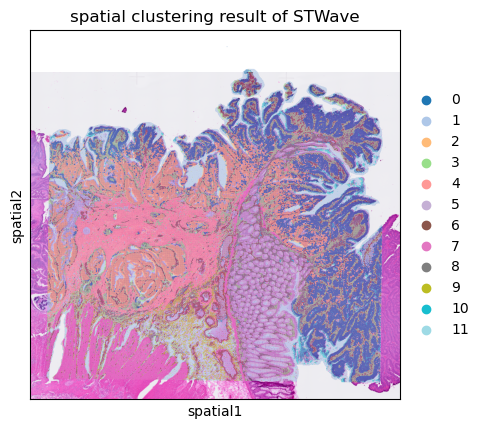

In [9]:
sc.pl.spatial(adata, color='leiden',title='spatial clustering result of STWave', palette='tab20')